# Dowload data

In [1]:
!gdown 1BVjrYwkQ69SPXhABMpaWCwVie2OPlXL6
!unzip -q data_word -d data

Downloading...
From (original): https://drive.google.com/uc?id=1BVjrYwkQ69SPXhABMpaWCwVie2OPlXL6
From (redirected): https://drive.google.com/uc?id=1BVjrYwkQ69SPXhABMpaWCwVie2OPlXL6&confirm=t&uuid=9759606b-f0c7-4de4-9c7e-a961c2f79396
To: /kaggle/working/data_word.zip
100%|███████████████████████████████████████| 1.46G/1.46G [00:13<00:00, 110MB/s]


In [ ]:
#!gdown 1JAbhGvyrNd8kkE9t92iZfLKppjyM1meU
#!unzip -q checkpoint-800 -d checkpoint-800

In [2]:
!gdown 1Xcz4lCqL8whIr6DB5kZB24RHyFaKciKC
!gdown 1Z4RxmO7wytSMALvpl5qB8X4Utn_HJe18
!unzip -q outputs_finetune -d outputs_finetune

Downloading...
From (original): https://drive.google.com/uc?id=1Xcz4lCqL8whIr6DB5kZB24RHyFaKciKC
From (redirected): https://drive.google.com/uc?id=1Xcz4lCqL8whIr6DB5kZB24RHyFaKciKC&confirm=t&uuid=2fae6753-3161-492f-ac1c-9199c2bfb32c
To: /kaggle/working/outputs_finetune.zip
100%|██████████████████████████████████████| 1.16G/1.16G [00:15<00:00, 76.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Z4RxmO7wytSMALvpl5qB8X4Utn_HJe18
To: /kaggle/working/split.json
100%|██████████████████████████████████████| 15.1M/15.1M [00:00<00:00, 20.6MB/s]


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


1
Tesla T4


# Installation

In [4]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install jiwer
!pip install einops addict easydict


In [5]:
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install jiwer
!pip install einops addict easydict

# Unsloth

In [6]:
#!pip install --upgrade --force-reinstall --no-cache-dir --no-deps unsloth unsloth_zoo transformers timm

from huggingface_hub import snapshot_download
snapshot_download("unsloth/DeepSeek-OCR", local_dir = "deepseek_ocr")

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

README-checkpoint.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

assets/show1.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

assets/show2.jpg:   0%|          | 0.00/216k [00:00<?, ?B/s]

assets/fig1.png:   0%|          | 0.00/396k [00:00<?, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

assets/show3.jpg:   0%|          | 0.00/247k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

assets/show4.jpg:   0%|          | 0.00/269k [00:00<?, ?B/s]

deepencoder.py: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

processor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

'/kaggle/working/deepseek_ocr'

In [7]:
import os, logging
os.environ["UNSLOTH_WARN_UNINITIALIZED"] = "0"

# Gỡ các handler dạng Unsloth khỏi logger transformers.modeling_utils
logger = logging.getLogger("transformers.modeling_utils")
new_handlers = []
for h in logger.handlers:
    # Unsloth thường đặt handler có class name đặc trưng, ta lọc theo tên
    if "Unsloth" in h.__class__.__name__:
        continue
    new_handlers.append(h)
logger.handlers = new_handlers


# Import

In [8]:
import os, json, random, argparse, unicodedata
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

import torch
from jiwer import wer, cer
#from huggingface_hub import snapshot_download

#from unsloth import FastVisionModel, is_bf16_supported
from transformers import AutoModel, Trainer, TrainingArguments

2025-12-14 04:59:40.762176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765688380.974449      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765688381.036229      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [10]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


# Fine-Tuning

In [11]:
# ========= (1) Text utils =========
def normalize_text(s: str) -> str:
    # Giữ dấu tiếng Việt ổn định (NFC), normalize whitespace nhẹ
    s = unicodedata.normalize("NFC", s or "")
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = " ".join(s.split())
    return s.strip()

def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Data Prep

In [12]:
# ========= (2) Data loader: scan .png/.txt pairs =========
def collect_pairs(root: str, recursive: bool = True) -> List[Dict[str, str]]:
    """
    Expect:
      <stem>.png
      <stem>.txt   (ground truth)
    Return list of {"image_path": ..., "text": ...}
    """
    items = []
    walker = os.walk(root) if recursive else [(root, [], os.listdir(root))]
    for d, _, files in walker:
        pngs = [f for f in files if f.lower().endswith(".png")]
        for png in pngs:
            stem = png[:-4]
            txt = stem + ".txt"
            img_path = os.path.join(d, png)
            txt_path = os.path.join(d, txt)
            if not os.path.exists(txt_path):
                continue
            with open(txt_path, "r", encoding="utf-8-sig") as f:
                gt = normalize_text(f.read())
            if gt == "":
                continue
            items.append({"image_path": img_path, "text": gt})
    return items

# ========= (3) Conversation format =========
def to_conversation(sample: Dict[str, str], instruction: str) -> Dict[str, Any]:
    # NOTE: để nhẹ RAM, ta truyền image_path (string) và collator sẽ tự Image.open
    return {
        "messages": [
            {"role": "<|User|>", "content": instruction, "images": [sample["image_path"]]},
            {"role": "<|Assistant|>", "content": sample["text"]},
        ]
    }


## Create datacollator

In [13]:
# ========= (4) Collator (dựa trên class bạn đang dùng, thêm hỗ trợ path string) =========
import math, io
from PIL import Image, ImageOps
from torch.nn.utils.rnn import pad_sequence
from deepseek_ocr.modeling_deepseekocr import text_encode, BasicImageTransform, dynamic_preprocess

class DeepSeekOCRDataCollator:
    def __init__(self, tokenizer, model, image_size=640, base_size=1024, crop_mode=True, train_on_responses_only=True):
        self.tokenizer = tokenizer
        self.model = model
        self.image_size = image_size
        self.base_size = base_size
        self.crop_mode = crop_mode
        self.image_token_id = 128815
        self.dtype = model.dtype
        self.train_on_responses_only = train_on_responses_only

        self.image_transform = BasicImageTransform(
            mean=(0.5, 0.5, 0.5),
            std=(0.5, 0.5, 0.5),
            normalize=True
        )
        self.patch_size = 16
        self.downsample_ratio = 4

        self.bos_id = tokenizer.bos_token_id if getattr(tokenizer, "bos_token_id", None) is not None else 0

    def deserialize_image(self, image_data) -> Image.Image:
        # ====== PATCH quan trọng cho dataset của bạn: support path string ======
        if isinstance(image_data, str):
            return Image.open(image_data).convert("RGB")
        if isinstance(image_data, Image.Image):
            return image_data.convert("RGB")
        if isinstance(image_data, dict):
            if "bytes" in image_data:
                image = Image.open(io.BytesIO(image_data["bytes"]))
                return image.convert("RGB")
            if "path" in image_data:
                return Image.open(image_data["path"]).convert("RGB")
        raise ValueError(f"Unsupported image format: {type(image_data)}")

    def process_image(self, image: Image.Image):
        images_list, images_crop_list, images_spatial_crop = [], [], []

        if self.crop_mode:
            if image.size[0] <= 640 and image.size[1] <= 640:
                crop_ratio = (1, 1)
                images_crop_raw = []
            else:
                images_crop_raw, crop_ratio = dynamic_preprocess(
                    image, min_num=2, max_num=9, image_size=self.image_size, use_thumbnail=False
                )

            global_view = ImageOps.pad(
                image, (self.base_size, self.base_size),
                color=tuple(int(x * 255) for x in self.image_transform.mean)
            )
            images_list.append(self.image_transform(global_view).to(self.dtype))

            width_crop_num, height_crop_num = crop_ratio
            images_spatial_crop.append([width_crop_num, height_crop_num])

            if width_crop_num > 1 or height_crop_num > 1:
                for crop_img in images_crop_raw:
                    images_crop_list.append(self.image_transform(crop_img).to(self.dtype))

            num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
            num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

            tokenized_image = ([self.image_token_id] * num_queries_base + [self.image_token_id]) * num_queries_base
            tokenized_image += [self.image_token_id]
            if width_crop_num > 1 or height_crop_num > 1:
                tokenized_image += ([self.image_token_id] * (num_queries * width_crop_num) + [self.image_token_id]) * (
                    num_queries * height_crop_num
                )
        else:
            crop_ratio = (1, 1)
            images_spatial_crop.append([1, 1])

            global_view = ImageOps.pad(
                image, (self.base_size, self.base_size),
                color=tuple(int(x * 255) for x in self.image_transform.mean)
            )
            images_list.append(self.image_transform(global_view).to(self.dtype))

            num_queries = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
            tokenized_image = ([self.image_token_id] * num_queries + [self.image_token_id]) * num_queries
            tokenized_image += [self.image_token_id]

        return images_list, images_crop_list, images_spatial_crop, tokenized_image

    def process_single_sample(self, messages: List[Dict]) -> Dict[str, Any]:
        images = []
        for m in messages:
            for img in m.get("images", []) or []:
                images.append(self.deserialize_image(img))

        tokenized_str, images_seq_mask = [], []
        images_list, images_crop_list, images_spatial_crop = [], [], []
        prompt_token_count = -1
        assistant_started = False
        image_idx = 0

        tokenized_str.append(self.bos_id)
        images_seq_mask.append(False)

        for m in messages:
            role = m["role"]
            content = m["content"]

            if role == "<|Assistant|>":
                if not assistant_started:
                    prompt_token_count = len(tokenized_str)
                    assistant_started = True
                content = f"{content.strip()} {self.tokenizer.eos_token}"

            text_splits = content.split("<image>")
            for i, text_part in enumerate(text_splits):
                tok = text_encode(self.tokenizer, text_part, bos=False, eos=False)
                tokenized_str.extend(tok)
                images_seq_mask.extend([False] * len(tok))

                if i < len(text_splits) - 1:
                    img = images[image_idx]
                    il, cl, sc, tok_img = self.process_image(img)
                    images_list.extend(il)
                    images_crop_list.extend(cl)
                    images_spatial_crop.extend(sc)

                    tokenized_str.extend(tok_img)
                    images_seq_mask.extend([True] * len(tok_img))
                    image_idx += 1

        if not assistant_started:
            prompt_token_count = len(tokenized_str)

        images_ori = torch.stack(images_list, dim=0)
        images_spatial_crop_tensor = torch.tensor(images_spatial_crop, dtype=torch.long)
        images_crop = torch.stack(images_crop_list, dim=0) if images_crop_list else torch.zeros(
            (1, 3, self.base_size, self.base_size), dtype=self.dtype
        )

        return {
            "input_ids": torch.tensor(tokenized_str, dtype=torch.long),
            "images_seq_mask": torch.tensor(images_seq_mask, dtype=torch.bool),
            "images_ori": images_ori,
            "images_crop": images_crop,
            "images_spatial_crop": images_spatial_crop_tensor,
            "prompt_token_count": prompt_token_count,
        }

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        batch_data = [self.process_single_sample(f["messages"]) for f in features]

        input_ids_list = [x["input_ids"] for x in batch_data]
        images_seq_mask_list = [x["images_seq_mask"] for x in batch_data]
        prompt_counts = [x["prompt_token_count"] for x in batch_data]

        input_ids = pad_sequence(input_ids_list, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        images_seq_mask = pad_sequence(images_seq_mask_list, batch_first=True, padding_value=False)

        labels = input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        labels[images_seq_mask] = -100
        for i, pc in enumerate(prompt_counts):
            if pc > 0:
                labels[i, :pc] = -100

        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()
        images_batch = [(x["images_crop"], x["images_ori"]) for x in batch_data]
        images_spatial_crop = torch.cat([x["images_spatial_crop"] for x in batch_data], dim=0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "images": images_batch,
            "images_seq_mask": images_seq_mask,
            "images_spatial_crop": images_spatial_crop,
        }


## Inference and eval

In [14]:
# ========= (5) Inference helper =========
@torch.inference_mode()
def ocr_one(model, tokenizer, image_path: str, prompt: str, base_size=1024, image_size=640, crop_mode=True) -> str:
    out = model.infer(
        tokenizer,
        prompt=prompt,
        image_file=image_path,
        output_path="outputs",
        base_size=base_size,
        image_size=image_size,
        crop_mode=crop_mode,
        save_results=False,
        test_compress=False,
    )
    # robust parse
    if isinstance(out, str):
        return normalize_text(out)
    if isinstance(out, list) and len(out) > 0:
        return normalize_text(str(out[0]))
    if isinstance(out, dict):
        for k in ["text", "result", "output"]:
            if k in out:
                return normalize_text(str(out[k]))
    return normalize_text(str(out))

def eval_loop(model, tokenizer, samples: List[Dict[str, str]], prompt: str,
              base_size=1024, image_size=640, crop_mode=True, max_eval=None) -> Dict[str, float]:
    if max_eval is not None:
        samples = samples[:max_eval]

    y_true, y_pred = [], []
    for s in samples:
        gt = normalize_text(s["text"])
        pr = ocr_one(model, tokenizer, s["image_path"], prompt, base_size, image_size, crop_mode)
        y_true.append(gt)
        y_pred.append(pr)

    return {
        "cer": float(cer(y_true, y_pred)),
        "wer": float(wer(y_true, y_pred)),
        "n": len(samples),
    }

## Main

In [9]:
# ========= (6) Main =========
def main1():
    ap = argparse.ArgumentParser()
    ap.add_argument("--data_dir", type=str, required=True)
    ap.add_argument("--out_dir", type=str, default="outputs/handwriting_lora")
    ap.add_argument("--val_ratio", type=float, default=0.05)
    ap.add_argument("--seed", type=int, default=3407)

    ap.add_argument("--max_steps", type=int, default=800)
    ap.add_argument("--lr", type=float, default=2e-4)
    ap.add_argument("--bsz", type=int, default=2)
    ap.add_argument("--gas", type=int, default=4)

    ap.add_argument("--image_size", type=int, default=640)
    ap.add_argument("--base_size", type=int, default=1024)
    ap.add_argument("--crop_mode", action="store_true")

    ap.add_argument("--max_eval", type=int, default=200)  # eval nhanh
    args = ap.parse_args()

    set_seed(args.seed)
    os.makedirs(args.out_dir, exist_ok=True)

    # Prompt: nên “cứng” và nhất quán cho chữ viết tay
    PROMPT = "<image>\nHãy chép lại nguyên văn chữ viết tay trong ảnh. Giữ đúng dấu tiếng Việt. "

    # 1) Download model snapshot
    #snapshot_download("unsloth/DeepSeek-OCR", local_dir="deepseek_ocr")

    # 2) Load base model
    model, tokenizer = FastVisionModel.from_pretrained(
        "unsloth/DeepSeek-OCR",
        load_in_4bit=False,
        auto_model=AutoModel,
        trust_remote_code=True,
        unsloth_force_compile=True,
        use_gradient_checkpointing="unsloth",
    )


    # 3) Load dataset
    import json, random

    pairs = collect_pairs(args.data_dir, recursive=True)
    rng = random.Random(42)
    rng.shuffle(pairs)

    n_val = max(1, int(len(pairs)*0.1))
    split = {"train": pairs[n_val:], "val": pairs[:n_val]}

    # Save train/val
    with open("split.json", "w", encoding="utf-8") as f:
        json.dump(split, f, ensure_ascii=False, indent=2)
    train_pairs = split["train"]
    val_pairs = split["val"]
    print(f"Total: {len(pairs)} | Train: {len(train_pairs)} | Val: {len(val_pairs)}")

    # 4) Baseline eval before finetune
    FastVisionModel.for_inference(model)
    base_metrics = eval_loop(
        model, tokenizer, val_pairs, PROMPT,
        base_size=args.base_size, image_size=args.image_size, crop_mode=args.crop_mode,
        max_eval=args.max_eval
    )
    print("Baseline:", base_metrics)

    # 5) Add LoRA (same target_modules)
    FastVisionModel.for_training(model)
    model = FastVisionModel.get_peft_model(
        model,
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
        r=16,
        lora_alpha=16,
        lora_dropout=0,
        bias="none",
        random_state=args.seed,
        use_rslora=False,
        loftq_config=None,
    )

    # 6) Convert to conversations
    train_conv = [to_conversation(s, PROMPT) for s in train_pairs]
    val_conv = [to_conversation(s, PROMPT) for s in val_pairs]

    # 7) Trainer
    collator = DeepSeekOCRDataCollator(
        tokenizer=tokenizer,
        model=model,
        image_size=args.image_size,
        base_size=args.base_size,
        crop_mode=args.crop_mode,
        train_on_responses_only=True,
    )

    targs = TrainingArguments(
        output_dir=args.out_dir,
        per_device_train_batch_size=args.bsz,
        gradient_accumulation_steps=args.gas,
        learning_rate=args.lr,
        warmup_steps=20,
        max_steps=args.max_steps,
        logging_steps=10,
        save_steps=100,
        optim="adamw_8bit",
        weight_decay=0.001,
        lr_scheduler_type="linear",
        seed=args.seed,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        report_to="none",
        dataloader_num_workers=2,
        remove_unused_columns=False,  # quan trọng cho vision finetune
    )

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=collator,
        train_dataset=train_conv,
        args=targs,
    )

    #trainer.train()
    trainer.train(resume_from_checkpoint="/kaggle/working/checkpoint-800/checkpoint-800")
    print("Done Train")
    # 8) Save LoRA adapters
    model.save_pretrained(os.path.join(args.out_dir, "lora_model"))
    tokenizer.save_pretrained(os.path.join(args.out_dir, "lora_model"))

    # 9) Eval after finetune
    FastVisionModel.for_inference(model)
    ft_metrics = eval_loop(
        model, tokenizer, val_pairs, PROMPT,
        base_size=args.base_size, image_size=args.image_size, crop_mode=args.crop_mode,
        max_eval=args.max_eval
    )
    print("Finetuned:", ft_metrics)

    # 10) Write report
    report = {"baseline": base_metrics, "finetuned": ft_metrics, "train_size": len(train_pairs), "val_size": len(val_pairs)}
    with open(os.path.join(args.out_dir, "eval_report.json"), "w", encoding="utf-8") as f:
        json.dump(report, f, ensure_ascii=False, indent=2)


# Run

In [10]:
if __name__ == "__main__":
  import sys
  DATA_DIR = "/kaggle/working/data/InkData_word_processed"
  sys.argv = ["train_handwriting.py",
              "--data_dir", DATA_DIR,
              "--out_dir", "outputs/handwriting_lora",
              "--max_steps", "1000",
              "--crop_mode"]
  main1()


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.5: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at unsloth/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Total: 110746 | Train: 99672 | Val: 11074








































































The image you've uploaded is a simple line drawing of a person's face. The person is facing forward, with their eyes looking straight ahead. The lines are clean and smooth, giving the drawing a minimalist and modern feel. The person's hair is short and neatly styled, and their facial features are simple and uncomplicated. The image is in black and white, which adds to its clean and minimalist aesthetic. The person's expression is neutral, and they seem to be looking directly at the viewer. The overall style of the image is simple and modern, with a focus on clean lines and minimal detail.


A simple line drawing of a banana.































































































A line drawing of a person with a hat on, holding a cane, and a cane in hand.


A. B. C. D.

























Baseline: {'cer': 1.1713859910581221, 'we

/tmp/ipykernel_774/613679430.py:115: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer._unsloth___init__`. Use `processing_class` instead.
  trainer = Trainer(
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 99,672 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 77,509,632 of 3,413,615,872 (2.27% trained)
	save_steps: 100 (from args) != 200 (from trainer_state.json)
Unsloth: Not an error, but DeepseekOCRForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
810,0.220500
820,0.214800
830,0.236600
840,0.230500
850,0.265400
860,0.183900
870,0.283900
880,0.209300
890,0.203800
900,0.254700


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Done Train


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


vẻ 
mặt 
xuống 
thuốc 
hơn 
vỏ 
bê 
giá 
để 
Gồm 
Ông 
tâm 
Tôi 
nhóm 
Sức 
Thật 
Vùng 
phí 
công 
chương 
hiện 
giấy 
Ngày 
bạn 
thể 
sau 
 buổi 
dài 
và 
chủ 
Giám 
là 
mua 
đa 
quay 
Nghị 
phản 
nhi 
Nhân 
cao 
sẽ 
gấp 
đầm 
rồi 
chủ 
vĩnh 
trong 
Tổng 
Cầu 
đi 
nhanh 
chống 
nhận 
biết 
các 
để 
lời 
Nơi 
cho 
một 
chuẩn 
chiến 
các 
Thông 
bị 
Liệu 
núi 
Văn 
nghĩa 
cuộc 
trưởng 
quan 
định 
xã 
ý ý 
cơ 
các 
tại 
Mai 
ở 
vắng 
Trường 
trở 
mái 
giúp 
giảm 
việc 
đứng 
triển 
ra 
3 
cùng 
tra 
có 
để 
thất 
về 
nước 
trình 
đường 
Thứ 
UBND 
nhiều 
3 
rành 
Thành 
chiến 
giúp 
lại 
lại 
khẩn 
tới 
và 
Yum 
hộ 
nhỏ 
Đại 
phát 
mô 
Hai 
trẻ 
diệu 
tử 
vợ 
nguy 
khóc 
là 
trưởng 
Việc 
mức 
kiếm 
nhỏ 
cấp 
sự 
1997 
sẽ 
câu 
xóa 
người 
một 
HĐND 
bỏ 
qua 
tới 
từ 
từ 
ấy 
ngẫm 
Honda 
đã 
mở 
khoảng 
thì thì 
người 
hai 
bà 
khắc 
người 
con 
thường 
trái 
cung 
triệt 
Nhiều 
bợ 
đi 
giờ 
chất 
gần 
đó 
750 
biển 
cho 
cấp 
tân 
số 
xác 
hết 
mảy 
Người 
cấp 
cường 
buồn 
là 
hiện 


In [11]:
print("Done!")

Done!


In [12]:
!cd /kaggle/working && zip -r lora_model.zip outputs/handwriting_lora/lora_model

  adding: outputs/handwriting_lora/lora_model/ (stored 0%)
  adding: outputs/handwriting_lora/lora_model/tokenizer.json (deflated 79%)
  adding: outputs/handwriting_lora/lora_model/tokenizer_config.json (deflated 97%)
  adding: outputs/handwriting_lora/lora_model/adapter_config.json (deflated 56%)
  adding: outputs/handwriting_lora/lora_model/special_tokens_map.json (deflated 67%)
  adding: outputs/handwriting_lora/lora_model/README.md (deflated 65%)
  adding: outputs/handwriting_lora/lora_model/adapter_model.safetensors (deflated 8%)


# Evaluate

In [19]:
import json, os

def load_split(split_path):
    with open(split_path, "r", encoding="utf-8") as f:
        split = json.load(f)
    train_pairs = split["train"]
    val_pairs   = split["val"]

    # sanity check
    assert isinstance(val_pairs, list) and len(val_pairs) > 0
    assert "image_path" in val_pairs[0] and "text" in val_pairs[0]
    print("Loaded split:", split_path)
    print("Train:", len(train_pairs), "Val:", len(val_pairs))
    print("Example:", val_pairs[0])
    return train_pairs, val_pairs


In [19]:
from unsloth import FastVisionModel
from transformers import AutoModel
from peft import PeftModel

BASE_ID = "unsloth/DeepSeek-OCR"
LORA_DIR = "/kaggle/working/outputs_finetune/outputs/handwriting_lora/lora_model"

model, tokenizer = FastVisionModel.from_pretrained(
    BASE_ID,
    load_in_4bit=True,
    auto_model=AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
)

model = PeftModel.from_pretrained(model, LORA_DIR)
FastVisionModel.for_inference(model)


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.5: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at unsloth/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): DeepseekOCRForCausalLM(
      (model): DeepseekOCRModel(
        (embed_tokens): Embedding(129280, 1280)
        (layers): ModuleList(
          (0): DeepseekV2DecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1280, out_features=1280, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1280, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bi

In [20]:
_, val_pairs = load_split("/kaggle/working/split.json")

PROMPT = "<image>\nHãy chép lại nguyên văn chữ viết tay trong ảnh. Giữ đúng dấu tiếng Việt. "

ft_metrics = eval_loop(
    model, tokenizer, val_pairs, PROMPT,
    base_size=1024, image_size=640, crop_mode=True,
    max_eval=200
)
print("Finetuned:", ft_metrics)


Loaded split: /kaggle/working/split.json
Train: 99672 Val: 11074
Example: {'image_path': '/kaggle/working/data/InkData_word_processed/20150305_0036_9415_2_tg_4_1_1.png', 'text': 'vô'}
về 
mặt 
xưởng 
thuốc 
tản 
vỏ 
bê 
giá 
để 
Còn 
động 
tâm 
Tp 
nhân 
sức 
Thật 
vùng 
phí 
công 
chương 
hơn 
giấy 
Ngày 
bạn 
thể 
sau 
biểu 
dài 
và 
chủ 
Giám 
là 
mua 
đa 
quay 
Văn 
phản 
nhi 
nhân 
cao 
sẽ 
gấp 
đất 
tôi 
chủ 
rình 
trong 
Tăng 
Còn 
đi 
nhành 
chẳng 
phận 
biết 
các 
để 
bởi 
Hải 
cho 
một 
chưa 
chính 
các 
Thông 
bị 
liệu 
nêu 
Năm 
nghĩa 
cuộc 
trưởng 
quan 
định 
xã 
ý ý 
cơ 
các 
tại 
Mai 
ở 
vắng 
Trường 
tổ 
mái 
giúp 
giảm 
việc 
đứng 
triển 
ra 
3 
cùng 
tra 
có 
để 
thật 
về 
nước 
tình 
tưởng 
thứ 
UBND 
nhiều 
3 
tành 
Thành 
chiến 
giáp 
lại 
xịt 
khăn 
tới 
và 
trên 
hộ 
nhỏ 
Đại 
phát 
mô 
tại 
tư 
diện 
tư 
vợ 
nguy 
kéo 
là 
trưởng 
thể 
mức 
kiếm 
nhỏ 
cấp 
sự 
trong 
ở 
câu 
xóa 
người 
nhật 
HĐND 
bỏ 
qua 
tử 
từ 
từ 
cấp 
ngẫm 
toanh 
đã 
nơi 
khoảng 
An 
ngư

In [21]:
del model
import gc, torch
gc.collect()
torch.cuda.empty_cache()

base_model, base_tok = FastVisionModel.from_pretrained(
    BASE_ID,
    load_in_4bit=True,
    auto_model=AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
)
FastVisionModel.for_inference(base_model)

base_metrics = eval_loop(
    base_model, base_tok, val_pairs, PROMPT,
    base_size=1024, image_size=640, crop_mode=True,
    max_eval=200
)
print("Baseline:", base_metrics)


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.5: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at unsloth/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


A curved line that resembles a smiley face.
A. mă
Ximong

A line drawing of a diamond shape with a line through the center.
A curved line that is part of the letter "C".A curved line that is part of the letter "C".A curved line that is part of a circle.

A
A. B. C. D.
A. CóB. Không
A: Cô, có bạn gặp lại không?B: Có, tôi đã gặp bạn lâu rồi.


A line drawing of a handwritten signature in the style of a person's signature.




A simple line drawing of a cat's face.

A curved line that resembles a smiley face.
A. Các chữ viết tay trong ảnh là: C, Đ, Đ, Đ, Đ, Đ, Đ, Đ, Đ, Đ, Đ, C, Đ, Đ, Đ, Đ, Đ, Đ, Đ, Đ, Đ.
A






A. Đầu tiên, chép lại nguyên văn chữ viết tay trong ảnh. B. Đầu tiên, chép lại nguyên văn chữ viết tay. C. Đầu tiên, chép lại nguyên văn chữ viết tay, đúng dấu tiếng Việt. D. Đầu tiên, chép lại nguyên văn chữ viết tay đúng dấu tiếng Việt.
A: Có - là - mẹA: Có - là - mẹA: Có - là - mẵA: Có - là - mẹA: Có - là - mấA: Có - là - mẹA: Có - là - mặA: Có - là - mẹA: Có - là - mẸA: Có - l

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (8192). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, A curved line resembling a crescent or a half-moon.
A curved line is written in the image. The correct punctuation mark is required.

A line drawing of a flower.
A line drawing of a handwritten signature in the style of a person.
A. B. C. D.

A line drawing of a handwritten signature in the style of a 19th-century French document.



A line drawing of a capital letter "M" with a circle above it and a line below it.
A: B:
A. Động viết tay trong ảnh là: B. Động viết tay trong ảnh là:
A

A handwritten note with the word "diamond"

## Eval 2

In [12]:
!pip -q install rapidfuzz

In [13]:
from rapidfuzz.distance import Levenshtein

def char_stats(gt: str, pr: str):
    # Levenshtein distance = S + D + I
    dist = Levenshtein.distance(gt, pr)
    n = max(len(gt), 1)
    cer = dist / n
    sim = max(0.0, 1.0 - cer)  # similarity
    return dist, cer, sim

def eval_loop_plus(model, tokenizer, samples, prompt,
                   base_size=1024, image_size=640, crop_mode=True, max_eval=None):
    import random
    if max_eval is not None and len(samples) > max_eval:
        samples = random.sample(samples, max_eval)

    y_true, y_pred = [], []
    exact = 0
    total_chars = 0
    total_dist = 0
    total_sim = 0.0

    for s in samples:
        gt = normalize_text(s["text"])
        pr = ocr_one(model, tokenizer, s["image_path"], prompt, base_size, image_size, crop_mode)

        y_true.append(gt); y_pred.append(pr)

        if pr == gt:
            exact += 1

        dist, cer_i, sim_i = char_stats(gt, pr)
        total_chars += max(len(gt), 1)
        total_dist += dist
        total_sim += sim_i

    # CER/WER gốc của bạn
    CER = float(cer(y_true, y_pred))
    WER = float(wer(y_true, y_pred))

    return {
        "cer": CER,
        "wer": WER,
        "exact_match": exact / len(samples),
        "avg_similarity": total_sim / len(samples),              # (0..1)
        "char_accuracy_like": 1.0 - (total_dist / total_chars),  # (0..1) gần nghĩa “ký tự đúng”
        "exact_word": exact,
        "n": len(samples),
    }


In [14]:
from unsloth import FastVisionModel
from transformers import AutoModel
from peft import PeftModel

BASE_ID = "unsloth/DeepSeek-OCR"
LORA_DIR = "/kaggle/working/outputs_finetune/outputs/handwriting_lora/lora_model"

model, tokenizer = FastVisionModel.from_pretrained(
    BASE_ID,
    load_in_4bit=True,
    auto_model=AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
    device_map={"": 0},   # ép tất cả lên GPU0, không offload CPU/disk
)

model = PeftModel.from_pretrained(model, LORA_DIR)
FastVisionModel.for_inference(model)


A new version of the following files was downloaded from https://huggingface.co/unsloth/DeepSeek-OCR:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/unsloth/DeepSeek-OCR:
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/unsloth/DeepSeek-OCR:
- modeling_deepseekocr.py
- conversation.py
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and 

Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.5: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at unsloth/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): DeepseekOCRForCausalLM(
      (model): DeepseekOCRModel(
        (embed_tokens): Embedding(129280, 1280)
        (layers): ModuleList(
          (0): DeepseekV2DecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1280, out_features=1280, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1280, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bi

In [18]:
_, val_pairs = load_split("/kaggle/working/split.json")

PROMPT = "<image>\nHãy chép lại nguyên văn chữ viết tay trong ảnh. Giữ đúng dấu tiếng Việt. "

metrics_plus = eval_loop_plus(model, tokenizer, val_pairs, PROMPT, max_eval=200,
                         base_size=1024, image_size=640, crop_mode=True)
print(f"Metric have cor word {metrics_plus}")


Loaded split: /kaggle/working/split.json
Train: 99672 Val: 11074
Example: {'image_path': '/kaggle/working/data/InkData_word_processed/20150305_0036_9415_2_tg_4_1_1.png', 'text': 'vô'}


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


xe 
hợi 
hạ 
Không 
quen 
cũng 
mới 
chức 
với 
là 
lượn 
của 
chận 
Xanh 
nội 
tay 
đồng 
Bản 
xác 
vã 
VN 
đã 
Hải 
khi 
1 
nơi 
thời 
có 
khách 
ở 
đặc 
số 
dám 
cùng 
cấp 
Rõ 
quan 
bỏ 
chở 
UBND 
biết 
hai 
cảnh 
đến 
có 
bàn 
mà 
là 
HCM 
tâm 
vừa 
tìm 
xin 
nước 
tục 
trách 
kiên 
những 
hàng 
ăn 
pháp 
ở 
mẹ 
Maestic 
nước 
Chiếc 
tn 
liên 
của 
2 
nước 
hân 
vụ 
biên 
hình 
ra 
ba 
trong 
xác 
hân 
khi 
lâu 
nhận 
tên 
mê 
phòng 
TB 
còn 
gia 
đất 
Ba 
giao 
văn 
này 
hiện 
cơ 
hóa 
hoảng 
có 
quai 
nghiệp 
tâu 
đi 
tiến 
một 
Sơn 
nhà 
sự 
thể 
gian 
quý 
Triết 
dý 
thay 
đai 
xã 
tra 
đặt 
tâm 
tư 
anh 
phạm 
bóng 
nơi 
hỏa 
Xuân 
Bình 
trái 
bộ 
lu 
quốc 
lên 
quá 
chủng 
người 
khi 
thật 
Hải 
cấp 
địa 
cho 
ngò 
nay 
đạm 
đơn 
các 
trong 
những 
khác 
vậy 
Bộ 
được 
lại 
là 
đồng 
đầu 
tổng 
bếp 
Xị 
trưc 
gặp 
Ba 
Văn 
biển 
bao 
cãi 
gia 
thịt 
giao 
HĐND 
của 
công 
Đã 
Sai 
cậu 
lý 
cùng 
những 
000 
quan 
vị 
đã 
đá 
Thắng 
tệ 
triển 
sản 
biển 
trực 
khu 
tục 
chất 

In [ ]:
report = {
    "finetuned": ft_metrics,
    "finetuned_metric": metrics_plus,
    "Baseline": base_metrics,
    "val_size": len(val_pairs),
    "split_path": SPLIT_PATH,
    "lora_dir": LORA_DIR,
}
out_path = "/kaggle/working/outputs_finetune/handwriting_lora/eval_report_reload.json"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print("Wrote:", out_path)


# Inference Test

In [13]:
import os, json, argparse, unicodedata
import torch
from unsloth import FastVisionModel
from transformers import AutoModel
from peft import PeftModel

def normalize_text1(s: str) -> str:
    s = unicodedata.normalize("NFC", s or "")
    s = " ".join(s.split())
    return s.strip()

def collect_image_paths1(path: str, recursive: bool = False):
    exts = (".png", ".jpg", ".jpeg", ".webp", ".bmp")
    if os.path.isfile(path):
        if path.lower().endswith(exts):
            return [path]
        raise ValueError(f"--image_dir is a file but not an image: {path}")

    if os.path.isdir(path):
        img_paths = []
        if recursive:
            for root, _, files in os.walk(path):
                for f in sorted(files):
                    if f.lower().endswith(exts):
                        img_paths.append(os.path.join(root, f))
        else:
            for f in sorted(os.listdir(path)):
                if f.lower().endswith(exts):
                    img_paths.append(os.path.join(path, f))
        return img_paths

    raise FileNotFoundError(f"--image_dir not found: {path}")

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.5: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at unsloth/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bản 


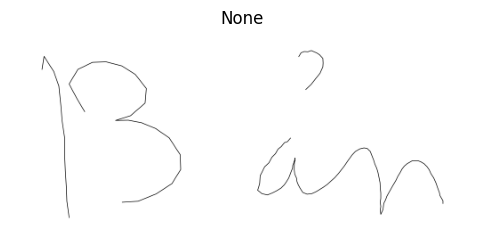

Done. Wrote 1 predictions to: pred_one.json


In [15]:
@torch.inference_mode()
def main2():
    ap = argparse.ArgumentParser()
    ap.add_argument("--image_dir", required=True, help="Path to an image file OR a directory of images")
    ap.add_argument("--lora_dir", required=True, help="Path to LoRA adapter folder (e.g. outputs/handwriting_lora/lora_model)")
    ap.add_argument("--out_json", default="preds.json")
    ap.add_argument("--base_model", default="unsloth/DeepSeek-OCR")
    ap.add_argument("--base_size", type=int, default=1024)
    ap.add_argument("--image_size", type=int, default=640)
    ap.add_argument("--crop_mode", action="store_true")
    ap.add_argument("--recursive", action="store_true", help="If image_dir is a folder, scan recursively")
    ap.add_argument("--output_dir", default="outputs_infer", help="Temp folder for model.infer output_path")
    args = ap.parse_args()

    PROMPT = "<image>\nHãy chép lại nguyên văn chữ viết tay trong ảnh. Giữ đúng dấu tiếng Việt. "

    # 1) Resolve images
    img_paths = collect_image_paths1(args.image_dir, recursive=args.recursive)
    if len(img_paths) == 0:
        raise RuntimeError(f"No images found in {args.image_dir}")

    os.makedirs(args.output_dir, exist_ok=True)

    # 2) Load base model
    model, tokenizer = FastVisionModel.from_pretrained(
        args.base_model,
        load_in_4bit=False,
        auto_model=AutoModel,
        trust_remote_code=True,
        unsloth_force_compile=True,
    )

    # 3) Apply LoRA adapter
    # args.lora_dir should be the folder you saved with:
    # model.save_pretrained(outputs/handwriting_lora/lora_model)
    model = PeftModel.from_pretrained(model, args.lora_dir)

    # 4) Inference mode
    FastVisionModel.for_inference(model)

    # 5) Run inference
    results = {}
    for p in img_paths:
        fname = os.path.basename(p)
        out = model.infer(
            tokenizer,
            prompt=PROMPT,
            image_file=p,
            output_path=args.output_dir,
            base_size=args.base_size,
            image_size=args.image_size,
            crop_mode=args.crop_mode,
            save_results=False,
            test_compress=False,
        )
        results[fname] = normalize_text1(out if isinstance(out, str) else str(out))

    # 6) Save JSON
    with open(args.out_json, "w", encoding="utf-8") as fp:
        json.dump(results, fp, ensure_ascii=False, indent=2)
    show_image_with_text(fname, results[fname])
    print(f"Done. Wrote {len(results)} predictions to: {args.out_json}")
import matplotlib.pyplot as plt
from PIL import Image

def show_image_with_text(img_path, text, figsize=(6,6)):
    img = Image.open(f"/kaggle/working/data/InkData_word_processed/{img_path}").convert("RGB")
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis("off")
    plt.title(text, fontsize=12, wrap=True)
    plt.show()

if __name__ == "__main__":
    import sys
    sys.argv = ["infer_handwriting.py",
                "--image_dir", "/kaggle/working/data/InkData_word_processed/20140603_0003_BCCTC_tg_0_0_0.png",
                "--lora_dir", "outputs/handwriting_lora/lora_model",
                "--out_json", "pred_one.json",
                "--base_size", "1024",
                "--image_size", "640",
                "--crop_mode"]
    main2()

    

In [16]:
!zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/images/ (stored 0%)
  adding: outputs/handwriting_lora/ (stored 0%)
  adding: outputs/handwriting_lora/checkpoint-1000/ (stored 0%)
  adding: outputs/handwriting_lora/checkpoint-1000/tokenizer.json (deflated 79%)
  adding: outputs/handwriting_lora/checkpoint-1000/tokenizer_config.json (deflated 97%)
  adding: outputs/handwriting_lora/checkpoint-1000/adapter_config.json (deflated 56%)
  adding: outputs/handwriting_lora/checkpoint-1000/scheduler.pt (deflated 56%)
  adding: outputs/handwriting_lora/checkpoint-1000/rng_state.pth (deflated 25%)
  adding: outputs/handwriting_lora/checkpoint-1000/special_tokens_map.json (deflated 67%)
  adding: outputs/handwriting_lora/checkpoint-1000/trainer_state.json (deflated 78%)
  adding: outputs/handwriting_lora/checkpoint-1000/README.md (deflated 65%)
  adding: outputs/handwriting_lora/checkpoint-1000/adapter_model.safetensors (deflated 8%)
  adding: outputs/handwriting_lora/checkpoint-1000/optimizer.pt

In [20]:
import hashlib, torch

def lora_fingerprint(model):
    h = hashlib.md5()
    cnt = 0
    for n, p in model.named_parameters():
        if "lora" in n:
            h.update(p.detach().cpu().float().numpy().tobytes())
            cnt += 1
    return cnt, h.hexdigest()
model, tokenizer = FastVisionModel.from_pretrained(
        "unsloth/DeepSeek-OCR",
        load_in_4bit=False,
        auto_model=AutoModel,
        trust_remote_code=True,
        unsloth_force_compile=True,
)
# trước train
cnt0, fp0 = lora_fingerprint(model)
print("before:", cnt0, fp0)

# sau train
model2 = PeftModel.from_pretrained(model, "outputs/handwriting_lora/lora_model")
cnt1, fp1 = lora_fingerprint(model2)
print("after :", cnt1, fp1)


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.5: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at unsloth/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


before: 0 d41d8cd98f00b204e9800998ecf8427e
after : 4392 d07f00e8d780c80c204da2e90c5622bc


# Eval 2

In [15]:
def normalize_text(text):
    # Chuyển về chữ thường và xóa khoảng trắng đầu đuôi
    return text.lower().strip()

def calculate_accuracy(predictions, ground_truths):
    correct_count = 0
    total_count = len(predictions)

    for pred, gt in zip(predictions, ground_truths):
        # Chuẩn hóa trước khi so sánh
        clean_pred = normalize_text(pred)
        clean_gt = normalize_text(gt)
        
        if clean_pred == clean_gt:
            correct_count += 1
        else:
            # In ra vài mẫu sai để debug
            if total_count < 5: 
                print(f"Sai: GT='{clean_gt}' vs Pred='{clean_pred}'")

    accuracy = correct_count / total_count
    return accuracy

# Ví dụ áp dụng
# Thay vì nhìn WER=1, hãy nhìn Accuracy. 
# Nếu Accuracy = 0 nghĩa là code xử lý chuỗi đang có vấn đề lớn.

In [16]:
from unsloth import FastVisionModel
from transformers import AutoModel
from peft import PeftModel

BASE_ID = "unsloth/DeepSeek-OCR"
LORA_DIR = "/kaggle/working/outputs_finetune/outputs/handwriting_lora/lora_model"

model, tokenizer = FastVisionModel.from_pretrained(
    BASE_ID,
    load_in_4bit=True,
    auto_model=AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
    device_map={"": 0},   # ép tất cả lên GPU0, không offload CPU/disk
)

model = PeftModel.from_pretrained(model, LORA_DIR)
FastVisionModel.for_inference(model)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/tmp/ipykernel_47/1470460709.py:1: UserWarning: WARNING: Unsloth should be imported before [transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastVisionModel


🦥 Unsloth Zoo will now patch everything to make training faster!


A new version of the following files was downloaded from https://huggingface.co/unsloth/DeepSeek-OCR:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/unsloth/DeepSeek-OCR:
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/unsloth/DeepSeek-OCR:
- modeling_deepseekocr.py
- conversation.py
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and 

Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.5: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at unsloth/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): DeepseekOCRForCausalLM(
      (model): DeepseekOCRModel(
        (embed_tokens): Embedding(129280, 1280)
        (layers): ModuleList(
          (0): DeepseekV2DecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1280, out_features=1280, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1280, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bi

In [25]:
from rapidfuzz.distance import Levenshtein
import random

# Hàm chuẩn hóa (Quan trọng nhất)
def normalize_text(text):
    if not isinstance(text, str): return ""
    # Chuyển về chữ thường, xóa khoảng trắng thừa, xóa dấu chấm câu thừa
    return text.lower().strip().strip('.')

def char_stats(gt: str, pr: str):
    # Levenshtein distance = Số thao tác sửa đổi để biến pr thành gt
    dist = Levenshtein.distance(gt, pr)
    n = max(len(gt), 1)
    cer_val = dist / n
    
    # Similarity: Giới hạn 0..1 (Nếu sai quá nhiều thì về 0)
    sim = max(0.0, 1.0 - cer_val) 
    return dist, cer_val, sim

def eval_loop_plus(model, tokenizer, samples, prompt,
                   base_size=1024, image_size=640, crop_mode=True, max_eval=None):
    
    # 1. Lấy mẫu ngẫu nhiên nếu dataset quá lớn
    if max_eval is not None and len(samples) > max_eval:
        samples = random.sample(samples, max_eval)

    y_true, y_pred = [], []
    exact = 0
    total_chars = 0
    total_dist = 0
    total_sim = 0.0
    debug_count = 0  # Đếm số lần in lỗi

    print(f"Đang đánh giá trên {len(samples)} mẫu...")

    for s in samples:
        # --- BƯỚC 1: CHUẨN HÓA CẢ HAI ---
        gt = normalize_text(s["text"])
        
        # Gọi hàm dự đoán (giả định hàm ocr_one trả về string)
        raw_pr = ocr_one(model, tokenizer, s["image_path"], prompt, base_size, image_size, crop_mode)
        pr = normalize_text(raw_pr) # <--- QUAN TRỌNG: Phải chuẩn hóa cả output của model

        y_true.append(gt)
        y_pred.append(pr)

        # --- BƯỚC 2: SO SÁNH ---
        if pr == gt:
            exact += 1
        else:
            # DEBUG: In ra 5 mẫu sai đầu tiên để kiểm tra
            if debug_count < 5:
                print(f"Sai: GT='{gt}' | PR='{pr}' (Raw: '{raw_pr}')")
                debug_count += 1

        # --- BƯỚC 3: TÍNH TOÁN CHI TIẾT ---
        dist, cer_i, sim_i = char_stats(gt, pr)
        total_chars += max(len(gt), 1)
        total_dist += dist
        total_sim += sim_i

    # Tính toán các chỉ số trung bình
    n_samples = len(samples)
    
    # Accuracy (Chính xác tuyệt đối)
    accuracy = exact / n_samples
    
    # Character Accuracy (Độ chính xác theo từng ký tự)
    char_acc = 1.0 - (total_dist / total_chars) if total_chars > 0 else 0

    return {
        "Accuracy (Exact Match)": accuracy,       # Đây là cái bạn cần nhất (0.0 -> 1.0)
        "Char Accuracy (Soft)": char_acc,         # Điểm an ủi (sai 1 chữ cái vẫn có điểm)
        "Avg Similarity": total_sim / n_samples,
        "Total Samples": n_samples,
        "Total Exact": exact
    }

In [26]:
_, val_pairs = load_split("/kaggle/working/split.json")

PROMPT = "<image>\nHãy chép lại nguyên văn chữ viết tay trong ảnh. Giữ đúng dấu tiếng Việt. "

# Gọi hàm mới
acc = eval_loop_plus(model, tokenizer, val_pairs, PROMPT, 
                     max_eval=200, 
                     base_size=1024, image_size=640, crop_mode=True)




Loaded split: /kaggle/working/split.json
Train: 99672 Val: 11074
Example: {'image_path': '/kaggle/working/data/InkData_word_processed/20150305_0036_9415_2_tg_4_1_1.png', 'text': 'vô'}
Đang đánh giá trên 200 mẫu...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


công 
Sai: GT='công' | PR='none' (Raw: 'none')
chốn 
Sai: GT='chốn' | PR='none' (Raw: 'none')
việc 
Sai: GT='việc' | PR='none' (Raw: 'none')
tra 
Sai: GT='tra' | PR='none' (Raw: 'none')
bị 
Sai: GT='bị' | PR='none' (Raw: 'none')
mất 
có 
cầu 
đứng 
nghiên 
mẹ 
tôi 
mưa 
đã 
nhiều 
nơi 
xưa 
người 
đoạn 
biển 
cho 
Phi 
cho 
như 
vì 
gấm 
25 
khổ 
chưởng 
đi 
dân 
con 
3 
sử 
không 
ngữ 
xin 
đúng 
của 
trên 
gà 
ngập 
cầu 
giảm 
bốn 
cới 
vụt 
An 
đất 
án 
ty 
xe 
tư 
chỉ 
đơn 
đất 
gần 
là 
tế 
tục 
chịu 
sức 
bắt 
mình 
hàng 
năm 
thất 
đó 
thiện 
nước 
lập 
lẽ 
đánh 
việc 
điểm 
lực 
này 
mâm 
giảm 
não 
mua 
hàng 
tiành 
sẽ 
bực 
Ngo 
Yến 
cấp 
trưởng 
được 
không 
tình 
đến 
khám 
trạm 
An 
tình 
bể 
biết 
giấy 
gì 
Theo 
tế 
sau 
thị 
tế 
án 
cạnh 
hiện 
tạo 
rất 
nữ 
xe 
phút 
phát 
VN 
nhiều 
tiết 
sẽ 
thập 
lên 
thì thì 
trưởng 
chỉ 
vệ 
tật 
đã 
dau 
Bí 
gần 
mới 
được 
chân 
quyền 
gà 
các 
mua 
6 
gà 
phiền 
biết 
Hau 
khi 
Sơn 
như 
5 
Lộ 
đến 
của 
nên 
sĩ 
bác 
để 
cấp 


TypeError: unsupported format string passed to dict.__format__

In [28]:
print(f"Final Accuracy: {acc}")

Final Accuracy: {'Accuracy (Exact Match)': 0.0, 'Char Accuracy (Soft)': -0.1959247648902822, 'Avg Similarity': 0.042666666666666665, 'Total Samples': 200, 'Total Exact': 0}
